# Quality Analysis on Real World Graphs

Graphs from https://www.cc.gatech.edu/dimacs10/archive/clustering.shtml

In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

import seaborn

In [2]:
data = {}

paths = glob.glob("../../data/results/all_real/*.json") # data on DSLM algorithms
paths += glob.glob("../../data/results/all_real_seq/*.json") # data on sequential and parallel algorithms - first five runs 
paths += glob.glob("../../data/results/all_real_seq2/*.json") # data on sequential and parallel algorithms - second five runs (splitted for no particular reason)
paths += glob.glob("../../data/results/gossip_map/*.json") # data on 5 gossip map runs without meltdown patches
paths += glob.glob("../../data/results/gossip_map2/*.json") # data on 5 more gossip map runs with meltdown patches
paths += glob.glob("../../data/results/louvain_baseline/*.json") # 5 more runs of the sequential louvain algorithm - intended so we can compare the other runs of louvain against them, but we ended up doing something different
paths += glob.glob("../../data/results/infomap_baseline/*.json") # 5 more runs of the sequential infomap algorithm - same as above
paths += glob.glob("../../data/results/all_real_cluster_cmp/*.json") # pairwise comparison data (a lot of data!)

for path in paths:
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Contraction'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix
seq_louvain_label = 'Seq. Louvain'
seq_infomap_label = 'Seq. InfoMap'
seq_infomap_directed_label = 'Seq. InfoMap directed'
plm_label = 'PLM'
relax_map_label = 'RelaxMap'
gossip_map_label = 'GossipMap'

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label,
    'sequential louvain': seq_louvain_label,
    'sequential infomap': seq_infomap_label,
    'sequential directed infomap': seq_infomap_directed_label,
    'relax map': relax_map_label,
    'gossip map': gossip_map_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [4]:
frames['program_run']['graph_path'] = frames['program_run']['graph']

graph_names = { 
    'data/graphs/uk-2002.metis-preprocessed-*.bin': 'uk-2002', 
    'data/graphs/uk-2007-05.metis-preprocessed-*.bin': 'uk-2007-05', 
    'data/graphs/in-2004.metis-preprocessed-*.bin': 'in-2004', 
    'data/graphs/com-friendster-preprocessed-*.bin': 'Friendster', 
    'data/graphs/com-lj.ungraph-preprocessed-*.bin': 'LiveJournal', 
    'data/graphs/com-orkut.ungraph-preprocessed-*.bin': 'Orkut', 
    'data/graphs/com-youtube.ungraph-preprocessed-*.bin': 'Youtube', 
    'data/graphs/com-amazon.ungraph-preprocessed-*.bin': 'Amazon',
    'data/graphs/europe.osm-preprocessed-*.bin': 'osm-europe',
}

frames['program_run'].replace({ 'graph': graph_names }, inplace=True)

## ARI Similarity against results of respective sequential baseline algorithm

- For each graph and algorithm - average over all ARI similarities to all clusterings obtained by the respective sequential baseline
- For example 10 runs of PLM will be compared to 10 runs of Louvain -> Average over 100 ARI scores
- Also 10 runs of Louvain will be compared among themselfs (but not to the exact same run) -> Average over 90 ARI scores
- Self similarities were excluded (already in the calculation of the similarities)

In [5]:
modularity_algos = [seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label]
mapeq_algos = [seq_infomap_label, seq_infomap_directed_label, relax_map_label, gossip_map_label, dlslm_me_label]

dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

data = frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .loc[lambda x: (x.path_x.str.contains('louvain_baseline') & x.algorithm_y.isin(modularity_algos)) | (x.path_x.str.contains('infomap_baseline') & x.algorithm_y.isin(mapeq_algos))]

comparison_data = data.groupby(['graph', 'algorithm_y'])['ARI'].mean().round(3).to_frame() \
    .unstack()["ARI"][modularity_algos + mapeq_algos]

res = comparison_data.reindex(['LiveJournal', 'Orkut', 'uk-2002', 'Friendster',  'uk-2007-05'])
print(res.to_latex().replace('NaN', 'oom'))
res

\begin{tabular}{lrrrrrrrrr}
\toprule
algorithm\_y &  Seq. Louvain &    PLM &  DSLM-Mod &  DSLM-Mod w/o Contraction &  Seq. InfoMap &  Seq. InfoMap directed &  RelaxMap &  GossipMap &  DSLM-Map \\
graph       &               &        &           &                           &               &                        &           &            &           \\
\midrule
LiveJournal &         0.568 &  0.570 &     0.500 &                     0.170 &         0.977 &                  0.974 &     0.373 &      0.780 &     0.767 \\
Orkut       &         0.592 &  0.600 &     0.555 &                     0.212 &         0.930 &                  0.935 &     0.819 &      0.498 &     0.828 \\
uk-2002     &         0.717 &  0.712 &     0.663 &                     0.047 &         0.984 &                  0.984 &     0.928 &      0.698 &     0.968 \\
Friendster  &         0.609 &  0.619 &     0.575 &                     0.365 &           oom &                    oom &       oom &        oom &       oom \\
uk-20

algorithm_y,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,
LiveJournal,0.568,0.570,0.500,0.170,0.977,0.974,0.373,0.780,0.767
Orkut,0.592,0.600,0.555,0.212,0.930,0.935,0.819,0.498,0.828
uk-2002,0.717,0.712,0.663,0.047,0.984,0.984,0.928,0.698,0.968
Friendster,0.609,0.619,0.575,0.365,NaN,NaN,NaN,NaN,NaN
uk-2007-05,0.875,0.882,0.823,0.281,NaN,NaN,NaN,NaN,NaN


## Average Modularity and Map Equation Scores for each algorithm respectively

In [6]:
modularity_algos = [seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label]
mapeq_algos = [seq_infomap_label, seq_infomap_directed_label, relax_map_label, gossip_map_label, dlslm_me_label]

modularity_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['modularity'].mean().round(3).to_frame() \
    .unstack()["modularity"][modularity_algos]
    
mapeq_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['map_equation'].mean().round(3).to_frame() \
    .unstack()["map_equation"][mapeq_algos]

res = modularity_data.loc[['LiveJournal', 'Orkut', 'uk-2002', 'Friendster',  'uk-2007-05']].merge(mapeq_data.loc[['LiveJournal', 'Orkut', 'uk-2002', 'Friendster',  'uk-2007-05']], left_index=True, right_index=True)
print(res.to_latex().replace('NaN', 'oom'))
res

\begin{tabular}{lrrrrrrrrr}
\toprule
algorithm &  Seq. Louvain &    PLM &  DSLM-Mod &  DSLM-Mod w/o Contraction &  Seq. InfoMap &  Seq. InfoMap directed &  RelaxMap &  GossipMap &  DSLM-Map \\
graph       &               &        &           &                           &               &                        &           &            &           \\
\midrule
LiveJournal &         0.752 &  0.752 &     0.749 &                     0.591 &         9.899 &                  9.900 &     9.943 &      9.963 &     9.981 \\
Orkut       &         0.664 &  0.666 &     0.658 &                     0.524 &        11.826 &                 11.825 &    11.849 &     11.979 &    11.896 \\
uk-2002     &         0.990 &  0.990 &     0.990 &                     0.879 &         6.458 &                  6.458 &     6.476 &      6.550 &     6.468 \\
Friendster  &         0.622 &  0.627 &     0.616 &                     0.553 &           oom &                    oom &       oom &     16.271 &    14.785 \\
uk-2007-

algorithm,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,
LiveJournal,0.752,0.752,0.749,0.591,9.899,9.900,9.943,9.963,9.981
Orkut,0.664,0.666,0.658,0.524,11.826,11.825,11.849,11.979,11.896
uk-2002,0.990,0.990,0.990,0.879,6.458,6.458,6.476,6.550,6.468
Friendster,0.622,0.627,0.616,0.553,NaN,NaN,NaN,16.271,14.785
uk-2007-05,0.996,0.996,0.996,0.919,NaN,NaN,NaN,9.034,8.057


## Best clustering for each graph by modularity score

In [7]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby('graph').apply(lambda x: x.sort_values(by=['modularity']).tail(1))[['algorithm', 'modularity']]

,,algorithm,modularity
graph,,,
Amazon,54c2f45c-cf63-4e2a-be77-1badee479311,DSLM-Mod,0.925840
Friendster,515ea262-07e5-4fbe-900a-1abb0046cf22,PLM,0.639539
LiveJournal,7606a589-a037-4cdd-93b6-4379a57e174d,Seq. Louvain,0.756122
Orkut,87173e44-6ab3-4529-aa83-de4a3ecdf3cb,Seq. Louvain,0.673316
Youtube,70fff9d4-ea6a-41bd-a4af-922130348bec,DSLM-Mod,0.723191
in-2004,66883653-088c-41ad-ac2e-17dbff4c0317,DSLM-Mod,0.980212
osm-europe,5fa0d4d7-037f-4c0c-86aa-3041ce897b51,DSLM-Mod,0.998896
uk-2002,1af8d902-a1b5-4d7a-9ace-1a18c64414c3,Seq. Louvain,0.989803
uk-2007-05,78480196-6770-4a21-8d26-d9b3564a505e,Seq. Louvain,0.996267


## Best clustering for each graph by map equation score

In [8]:
frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby('graph').apply(lambda x: x.sort_values(by=['map_equation']).head(1))[['algorithm', 'map_equation']]

,,algorithm,map_equation
graph,,,
Amazon,eed76e96-365e-41a7-a055-bb87e28c9533,GossipMap,5.286290
Friendster,6c9a3f8b-a33c-46a7-ac6f-6a30a6930494,DSLM-Map,14.773433
LiveJournal,b338c30d-0d31-4f09-abc9-f70c6e193e50,Seq. InfoMap directed,9.897800
Orkut,2013b050-de7e-4218-a2d0-bab9a3939ba5,Seq. InfoMap,11.822900
Youtube,c41bc442-1ea7-4ac9-b30a-631b81a423ea,GossipMap,8.521960
in-2004,c5830275-f97d-4170-be2a-e8628df296bf,DSLM-Map,6.292258
osm-europe,c83e910c-7747-4105-8991-7dcf2008c642,DSLM-Map,4.349054
uk-2002,856cbffa-e3a3-4cad-ac50-b3ca61e91de9,Seq. InfoMap directed,6.457620
uk-2007-05,07c81d70-0fa7-4cc3-8fb3-b11265b44603,DSLM-Map,8.056522


## Average Similarity to Best Clustering

In [9]:
modularity_algos = [seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label]
mapeq_algos = [seq_infomap_label, seq_infomap_directed_label, relax_map_label, gossip_map_label, dlslm_me_label]

best_mod_clustering_ids = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby('graph').apply(lambda x: x.sort_values(by=['modularity']).tail(1)).index.levels[1]

best_map_clustering_ids = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby('graph').apply(lambda x: x.sort_values(by=['map_equation']).head(1)).index.levels[1]

dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]
    
data = frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: (x.algorithm.isin(modularity_algos) & x.compare_clustering_id.isin(best_mod_clustering_ids)) | (x.algorithm.isin(mapeq_algos) & x.compare_clustering_id.isin(best_map_clustering_ids))]
    
comparison_data = data.groupby(['graph', 'algorithm'])['ARI'].mean().round(3).to_frame() \
    .unstack()["ARI"][modularity_algos + mapeq_algos]

res = comparison_data.loc[['LiveJournal', 'Orkut', 'uk-2002', 'Friendster',  'uk-2007-05']]
print(res.to_latex().replace('NaN', 'oom'))
res

\begin{tabular}{lrrrrrrrrr}
\toprule
algorithm &  Seq. Louvain &    PLM &  DSLM-Mod &  DSLM-Mod w/o Contraction &  Seq. InfoMap &  Seq. InfoMap directed &  RelaxMap &  GossipMap &  DSLM-Map \\
graph       &               &        &           &                           &               &                        &           &            &           \\
\midrule
LiveJournal &         0.571 &  0.639 &     0.600 &                     0.179 &         0.976 &                  0.973 &     0.376 &      0.784 &     0.769 \\
Orkut       &         0.632 &  0.625 &     0.659 &                     0.220 &         0.919 &                  0.925 &     0.807 &      0.491 &     0.819 \\
uk-2002     &         0.730 &  0.724 &     0.674 &                     0.047 &         0.986 &                  0.985 &     0.928 &      0.698 &     0.970 \\
Friendster  &         0.640 &  0.623 &     0.569 &                     0.361 &           oom &                    oom &       oom &      0.013 &     0.748 \\
uk-2007-

algorithm,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,
LiveJournal,0.571,0.639,0.600,0.179,0.976,0.973,0.376,0.784,0.769
Orkut,0.632,0.625,0.659,0.220,0.919,0.925,0.807,0.491,0.819
uk-2002,0.730,0.724,0.674,0.047,0.986,0.985,0.928,0.698,0.970
Friendster,0.640,0.623,0.569,0.361,NaN,NaN,NaN,0.013,0.748
uk-2007-05,0.873,0.877,0.816,0.279,NaN,NaN,NaN,0.132,0.986


## Average Modularity Scores

In [10]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['modularity'].mean().round(5).to_frame() \
    .unstack()["modularity"][modularity_algos + mapeq_algos]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data['edge_count'] = graph_data['edge_count'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,,,,
Amazon,334863,925872,2,NaN,NaN,0.92486,0.66281,NaN,NaN,NaN,0.82898,0.83069
Youtube,1134890,2987624,2,NaN,NaN,0.72019,0.58012,NaN,NaN,NaN,0.56252,0.57475
in-2004,1382867,13591473,4,NaN,NaN,0.98009,0.87737,NaN,NaN,NaN,0.94278,0.93869
LiveJournal,3997962,34681189,8,0.75154,0.75225,0.74874,0.59073,0.64283,0.64322,0.60210,0.62695,0.62566
osm-europe,50912018,54054660,8,NaN,NaN,0.99889,0.48728,NaN,NaN,NaN,0.93818,0.93858
Orkut,3072441,117185083,8,0.66351,0.66580,0.65841,0.52424,0.55879,0.55915,0.54033,0.54879,0.53847
uk-2002,18483186,261787258,8,0.98975,0.98971,0.98963,0.87904,0.95847,0.95854,0.96001,0.96330,0.95963
Friendster,65608366,1806067135,16,0.62236,0.62698,0.61610,0.55288,NaN,NaN,NaN,0.22453,0.47257
uk-2007-05,105153952,3301876564,16,0.99625,0.99626,0.99619,0.91855,NaN,NaN,NaN,0.95316,0.97236


## Average Map Equation Scores

In [11]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['map_equation'].mean().round(5).to_frame() \
    .unstack()["map_equation"][modularity_algos + mapeq_algos]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data['edge_count'] = graph_data['edge_count'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,,,,
Amazon,334863,925872,2,NaN,NaN,8.35257,6.42094,NaN,NaN,NaN,5.28859,5.30990
Youtube,1134890,2987624,2,NaN,NaN,10.31650,9.44385,NaN,NaN,NaN,8.52810,8.54753
in-2004,1382867,13591473,4,NaN,NaN,7.28067,6.67116,NaN,NaN,NaN,6.41078,6.29794
LiveJournal,3997962,34681189,8,11.83368,11.82572,11.92705,10.44676,9.89925,9.89987,9.94310,9.96251,9.98095
osm-europe,50912018,54054660,8,NaN,NaN,9.95216,10.42852,NaN,NaN,NaN,4.35686,4.34971
Orkut,3072441,117185083,8,12.94975,13.00040,12.96878,12.19252,11.82593,11.82527,11.84899,11.97924,11.89636
uk-2002,18483186,261787258,8,8.23305,8.24619,8.29748,7.04428,6.45790,6.45786,6.47612,6.55042,6.46789
Friendster,65608366,1806067135,16,15.64728,15.61850,15.66436,15.30138,NaN,NaN,NaN,16.27057,14.78516
uk-2007-05,105153952,3301876564,16,9.07099,9.07414,9.12773,8.40233,NaN,NaN,NaN,9.03421,8.05733


## Average Number of clusters in the clusterings obtained by each algorithm

plus the ratio between GossipMap and InfoMap

In [12]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['cluster_count'].mean().round(1).to_frame() \
    .unstack()["cluster_count"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
res = graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

res['relative_change'] = (res[gossip_map_label] - res[seq_infomap_label]) / res[seq_infomap_label]
res

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,RelaxMap,GossipMap,DSLM-Map,relative_change
graph,,,,,,,,,,,,
Amazon,334863,9.258720e+05,2,NaN,NaN,229.9,58315.1,NaN,NaN,15525.0,14232.2,NaN
Youtube,1134890,2.987624e+06,2,NaN,NaN,5228.5,210557.5,NaN,NaN,70122.2,52409.9,NaN
in-2004,1382867,1.359147e+07,4,NaN,NaN,925.6,104279.2,NaN,NaN,29672.2,27222.0,NaN
LiveJournal,3997962,3.468119e+07,8,2069.3,1860.8,1381.3,326716.3,85207.9,127963.5,122082.1,78016.0,0.432756
osm-europe,50912018,5.405466e+07,8,NaN,NaN,2746.1,22673150.8,NaN,NaN,2188946.8,2190102.1,NaN
Orkut,3072441,1.171851e+08,8,35.3,22.1,27.7,34199.9,14702.8,25164.1,17308.1,15381.8,0.177198
uk-2002,18483186,2.617873e+08,8,4956.9,4703.6,4679.4,951448.9,198287.5,242522.9,211446.8,186627.0,0.066365
Friendster,65608366,1.806067e+09,16,33752.6,24115.6,16925.3,1472293.1,NaN,NaN,1241722.6,584894.0,NaN
uk-2007-05,105153952,3.301877e+09,16,20244.1,20164.2,19856.8,2282674.0,NaN,NaN,560367.0,376449.5,NaN


## uk-2007-05 - All ARI similarities between DSLM-Mod (base side) and Seq Louvain (compare side)

ARI  \
compare_clustering_id                007c7522-cab6-4575-8bd6-2a54d24a84f2   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.762577   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.829717   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.772451   
60868699-459a-4796-bcd0-f7c469a64084                             0.797859   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.798875   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.806120   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.800890   
e0682069-6f72-42c7-b595-489e871b1058                             0.806097   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.807907   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.806202   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.805693   

                                                                           \
compare_clustering_id                0cf800e1-6b1f-4167-a8e4-3cd598486af7   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.776388   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.827440   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.782528   
60868699-459a-4796-bcd0-f7c469a64084                             0.823233   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.807150   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.820472   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.819147   
e0682069-6f72-42c7-b595-489e871b1058                             0.813013   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.806572   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.815790   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.817040   

                                                                           \
compare_clustering_id                159d7c72-b79a-47bd-bdd2-0007bd93b8c0   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.787404   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.826768   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.799542   
60868699-459a-4796-bcd0-f7c469a64084                             0.824294   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.823352   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.824826   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.831505   
e0682069-6f72-42c7-b595-489e871b1058                             0.826958   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.838033   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.831910   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.830950   

                                                                           \
compare_clustering_id                2487e372-e798-41e1-811a-eeb2ae9a76e0   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.788207   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.833793   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.800283   
60868699-459a-4796-bcd0-f7c469a64084                             0.821180   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.827680   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.824303   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.829115   
e0682069-6f72-42c7-b595-489e871b1058                           

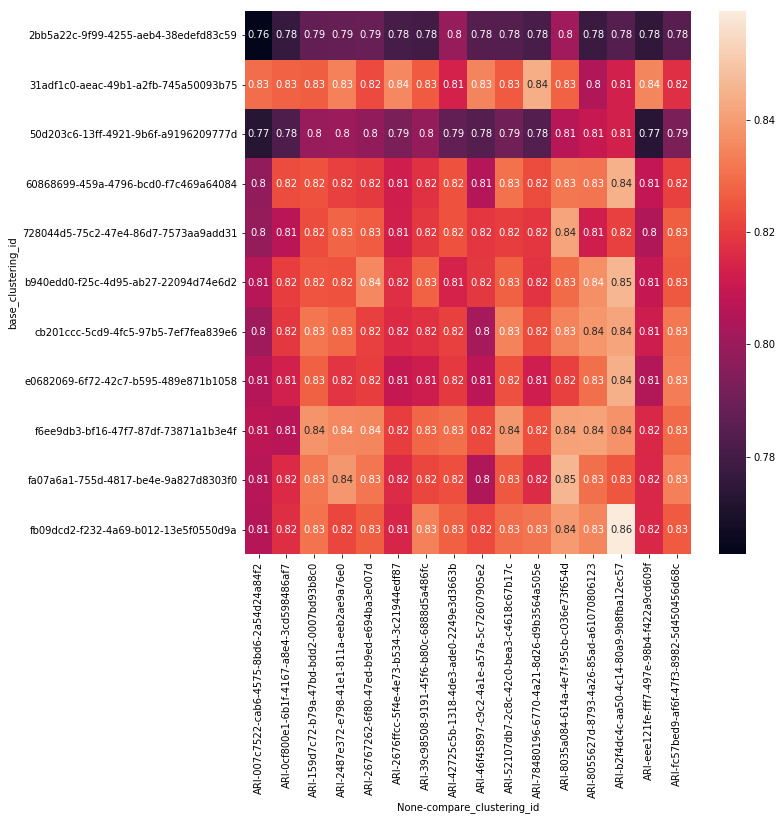

In [13]:
dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

df = frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id_y', right_index=True) \
    .loc[lambda x: x.graph_x == 'uk-2007-05'] \
    .loc[lambda x: ((x.algorithm_x == dlslm_label) & (x.algorithm_y == seq_louvain_label))] \
    [['base_clustering_id', 'compare_clustering_id', 'ARI']] \
    .set_index(['base_clustering_id', 'compare_clustering_id']).unstack()

mpl.pyplot.figure(figsize=(10, 10))
seaborn.heatmap(df, annot=True)
df

## Average ARI similarities between DSLM-Map and GossipMap

In [14]:
dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .loc[lambda x: ((x.algorithm_x == gossip_map_label) & (x.algorithm_y == dlslm_me_label))] \
    .groupby('graph')['ARI'].mean()

graph
Amazon         0.737702
Friendster     0.012046
LiveJournal    0.742477
Orkut          0.465135
Youtube        0.623087
in-2004        0.940228
osm-europe     0.594620
uk-2002        0.699999
uk-2007-05     0.131403
Name: ARI, dtype: float64